In [1]:
import os
import numpy as np
import pandas as pa
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import spectrogram
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
%matplotlib inline

In [2]:
csv = pa.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")

In [3]:
csv

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


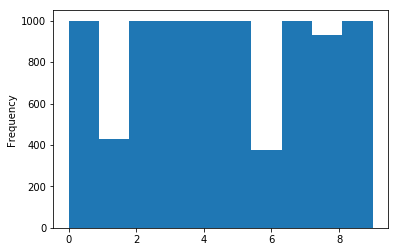

In [4]:
csv["classID"].plot.hist()

In [357]:
meta = pa.DataFrame(columns=["name", "fs", "n_samples", "duration", "label"])

In [358]:
num_calls = 0
num_corrupt = 0
corrupt_files = []

for folder in range(1,11):
    files = os.listdir("UrbanSound8K/audio/fold{}/".format(folder))
    files = [file for file in files if file.endswith(".wav")]
    files.sort()
    
    for file in files:
        num_calls += 1
        print(num_calls)
        try:
            signal, fs = sf.read("UrbanSound8K/audio/fold{}/{}".format(folder, file))
            signal = librosa.to_mono(y=signal.T)
            duration = signal.shape[0]/fs            
            
            if duration >= 4 and fs >= 44100:
                label = csv.loc[csv['slice_file_name'] == file]
                label = label["classID"].get_values()[0]
                
                if fs != 44100:
                    signal = librosa.resample(y=signal, orig_sr=fs, target_sr=44100)
                duration = signal.shape[0]/44100
                
                params = {}
                params.update({"name":file[0:-4]+".npy"})
                params.update({"fs":44100})
                params.update({"n_samples":signal.shape[0]})
                params.update({"label":label})
                params.update({"duration":duration}) 
                
                meta = meta.append(params, ignore_index=True)
                
                savepath = "data_npy/{}".format(file[0:-4])
                np.save(arr=signal, file=savepath)
        except:
            num_corrupt += 1 
            corrupt_files.append(file)
        clear_output(wait=True)

8732


In [354]:
meta

,name,fs,n_samples,duration,label
0,101415-3-0-2.npy,44100,192000,4.353741,3
1,101415-3-0-3.npy,44100,192000,4.353741,3
2,101415-3-0-8.npy,44100,192000,4.353741,3
3,102842-3-0-1.npy,44100,176400,4.000000,3
4,102842-3-1-0.npy,44100,176400,4.000000,3
5,102842-3-1-5.npy,44100,176400,4.000000,3
6,102842-3-1-6.npy,44100,176400,4.000000,3
7,103074-7-0-0.npy,44100,192000,4.353741,7
8,103074-7-0-1.npy,44100,192000,4.353741,7
9,103074-7-0-2.npy,44100,192000,4.353741,7
